<a href="https://colab.research.google.com/github/Med-Rokaimi/GAN_synthetic_data_time_series/blob/master/CGAN_oil_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from collections import namedtuple
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [ ]:
class Generator(nn.Module):
    def __init__(self, hidden_dim, feature_no, seq_len, output_dim, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = 1
        self.input_dim = feature_no
        self.output_dim = output_dim
        self.dropout = dropout
        self.seq_len = seq_len

        # LSTM layers
        self.lstm = nn.LSTM(
            self.input_dim + config.noise_size, self.hidden_dim, self.layer_dim, batch_first=True, bidirectional=True, dropout=self.dropout
        )
        self.gru = nn.GRU(self.hidden_dim * 2, self.hidden_dim, batch_first=True, bidirectional=True,
                          dropout=self.dropout)

        # Fully connected layer
        self.fc_1 = nn.Linear(self.hidden_dim * 2, 12)  # fully connected
        self.fc_2 = nn.Linear(12, self.output_dim)  # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self, x, noise, batch_size): # x = [batch_size, sequence_length, feature_no]

        # Initialize hidden state and cell state
        h0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim, device=x.device).requires_grad_()
        c0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        # Downsample the noise to match the sequence length of x_batch
        noise_downsampled = noise.unsqueeze(1).expand(-1, self.seq_len, -1)  # Shape: (batch_size, seq_length, noise_dim)
        noise_downsampled = noise_downsampled[:, :self.seq_len, :]  # Downsample to match the sequence length

        # Concatenate the noise with the input features along the feature dimension
        x_combined = torch.cat((x, noise_downsampled),
                               dim=-1)  # Shape: (batch_size, seq_length, features_number + noise_dim)

        out, (hn, cn) = self.lstm(x_combined, (h0, c0))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc_1(out)  # first dense
        out = self.relu(out)  # relu
        out = self.fc_2(out)  # final output
        return out

class Discriminator(nn.Module):
    def __init__(self, seq_len, hidden_dim):
        super().__init__()
        self.discriminator_latent_size = hidden_dim
        self.x_batch_size = seq_len
        self.input_to_latent = nn.GRU(input_size=1,
                                      hidden_size=hidden_dim)
        self.model = nn.Sequential(
            nn.Linear(in_features=hidden_dim, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, prediction, x_batch):
        # Ignore the extrnal feature SENT
        x_batch = x_batch[:, :, 0]  # batch x seq_len

        d_input = torch.cat((x_batch, prediction.view(-1, 1)),
                            dim=1)
        d_input = d_input.view(-1, self.x_batch_size + 1, 1)
        d_input = d_input.transpose(0, 1)
        d_latent, _ = self.input_to_latent(d_input)
        d_latent = d_latent[-1]
        output = self.model(d_latent)

        return output


In [ ]:
# helper functions
def generate_noise(noise_size, batch_size, noise_type, rs, params=None):
    noise = []
    if noise_type == 'normal':
        noise = rs.normal(0, 1, (batch_size, noise_size))
    elif noise_type == 'uniform':
        return torch.rand(batch_size, noise_size) * 2 - 1  # Uniform between -1 and 1
    else:
        raise ValueError(f"Unsupported noise type: {noise_type}")
    return torch.tensor(noise, dtype=torch.float32)


def load_real_samples(batch_size,x_train, y_train):
    idx = rs.choice(x_train.shape[0], batch_size)
    x_batch = x_train[idx]
    y_batch = y_train[idx]
    # print("loading real samples")
    return x_batch, y_batch


def generate_fake_samples(generator, noise_size, x_batch):

    noise_batch = generate_noise(noise_size, x_batch.size(0), config.noise_type, rs)

    y_fake = generator(x_batch, noise_batch, x_batch.size(0)).detach()
    # labels = zeros((x_batch.size(0), 1))  #Label=0 indicating they are fake
    return x_batch, y_fake

def calc_crps(ground_truth, predictions, predictions2):
    return np.absolute(predictions - ground_truth).mean() - 0.5 * np.absolute(predictions - predictions2).mean()


In [ ]:
#Dataset

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
mm = MinMaxScaler()
ss = StandardScaler()





def create_dataset(df, target, train_size, valid_size, test_size, seq_len, pred_len):

    data = data_prep(df, target, seq_len, pred_len, train_size, valid_size, test_size)
    return data

def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

def split_train_test_pred (X_ss, y_mm , train_test_cutoff, vald_size, predict_size):
    X_train = X_ss[:train_test_cutoff]
    X_valid = X_ss[train_test_cutoff: train_test_cutoff + vald_size]

    y_train = y_mm[:train_test_cutoff]
    y_valid = y_mm[train_test_cutoff: train_test_cutoff + vald_size]

    X_test = X_ss[-predict_size:]
    y_test = y_mm[-predict_size:]

    data = {"X_train": X_train, "y_train": y_train, "X_valid": X_valid, "y_valid": y_valid, "X_test": X_test,
            "y_test": y_test}
    return data

def normalize__my_data_(X, y):
  X_trans = ss.fit_transform(X)
  y_trans = mm.fit_transform(y.reshape(-1, 1))
  return X_trans, y_trans


def pytorch_data_input(data, batch_size):
    train_features = torch.Tensor(data['X_train'])
    train_targets = torch.Tensor(data['y_train'])
    val_features = torch.Tensor(data['X_valid'])
    val_targets = torch.Tensor(data['y_valid'])
    test_features = torch.Tensor(data['X_test'])
    test_targets = torch.Tensor(data['y_test'])

    train = TensorDataset(train_features, train_targets)
    val = TensorDataset(val_features, val_targets)
    test = TensorDataset(test_features, test_targets)

    # print(train.tensors)

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)
    return train_loader, val_loader, test_loader , test_loader_one

def data_prep(df, target,  seq_len, pred_len, train_size, valid_size, test_size):
    X, y = df, df[target].values
    # 5- Normalize
    X_trans, y_trans = normalize__my_data_(X, y)

    # 7- Build the sequence
    X_ss, y_mm = split_sequences(X_trans, y_trans, seq_len, pred_len)

    train_size = train_size
    train_test_cutoff = train_size
    vald_size = valid_size
    test_size = test_size
    # understand_data_values_for_split(num_of_samples, X, y)
    data = split_train_test_pred(X_ss, y_mm, train_test_cutoff, vald_size, test_size)
    # data = split_train_test_pred(X_trans, y_trans, train_test_cutoff, vald_size, test_size)
    return data


def data_to_tensor(data, device):
    x_train = torch.tensor(data['X_train'], device=device, dtype=torch.float32)
    y_train = torch.tensor(data['y_train'], device=device, dtype=torch.float32)
    x_val = torch.tensor(data['X_valid'], device=device, dtype=torch.float32)
    y_val = data['y_valid']
    return x_train, y_train, x_val, y_val


In [ ]:
#Plotting
def plot_losses(gen_losses, critic_losses, path, save = None):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator')
    plt.plot(critic_losses, label='Discriminator')
    plt.xlabel('Epoch')
    plt.ylabel(' Loss')
    plt.title('Generator and Critic Loss During Training')
    plt.legend()
    if save:
        plt.savefig(path + "/loss.png")
    plt.show()


def plot_gradiants(gen_gradients, critic_gradients, path, save = False):

    plt.figure(figsize=(10, 5))
    plt.plot(gen_gradients, label='Generator Gradients')
    plt.plot(critic_gradients, label='Discriminator Gradients')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient Magnitude')
    plt.title('Gradient Magnitude per Epoch')
    plt.legend()
    if save:
        plt.savefig(path + '/grad.png')
    plt.show()

def plot_trues_preds(trues, preds, path=False):
    print(trues.shape, preds.shape)
    plt.plot(trues)
    plt.plot(preds)
    plt.title('Actual vs generated data')
    plt.legend(['Actual', 'Generated'], loc='upper left')
    if path:
        plt.savefig(path + '/line.png', bbox_inches='tight')
    plt.show()

In [ ]:
# Evaluation



def MAE(pred, true):
    return np.mean(np.abs(pred - true))
def MSE(pred, true):
    return np.mean((pred - true) ** 2)
def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))
def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))
def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))

def r_2(preds, trues):
    return metrics.r2_score(trues, preds)  # R-Squared
from scipy.special import rel_entr
def kl_divergence(preds, trues):

    # Ensure that P and Q are probability distributions
    preds /= preds.sum()
    trues /= trues.sum()

    # Compute KL Divergence
    kl_div = np.sum(rel_entr(preds, trues))

    return kl_div

def metric(trues, preds):
    preds = np.round(preds, 2)
    trues = np.round(trues, 2)
    mae = MAE(preds, trues)
    mse = MSE(preds, trues)
    rmse = RMSE(preds, trues)
    mspe = MSPE(preds, trues)
    mape = MAPE(preds, trues)
    r2 = r_2(preds, trues)
    kl = kl_divergence(preds, trues)

    print(" MAE: {:.6f}  , MSE {:.6f}, RMSE {:.6f}, MSPE {:.6f}, MAPE {:.6f}, R2 {:.6f}, KL {:.6f}".format(mae, mse ,rmse ,mspe ,mape ,r2,kl))
    return {'mae':mae,'mse':mse,'rmse':rmse, 'mspe':mspe, 'mape':mape, 'r2':r2}


In [ ]:
def train(best_crps):
    best_gen = None
    import time
    start_time = time.time()  # Record the start time
    generator_losses, discriminator_losses, d_loss =  [], [], 0
    generator_gradients, discriminator_gradients = [], []

    for step in range(config.epochs):
        # load real samples
        # x_bach = batch x seq_len x feature_no
        # y_batch = batch_size x pred_len
        x_batch, y_batch = load_real_samples(config.batch_size, x_train, y_train)

        # train D on real samples
        discriminator.zero_grad()
        d_real_decision = discriminator(y_batch, x_batch)
        d_real_loss = adversarial_loss(d_real_decision,
                                       torch.full_like(d_real_decision, 1, device=device))
        d_real_loss.backward()
        d_loss += d_real_loss.detach().cpu().numpy()

        # train discriminator on fake data
        x_batch, y_fake = generate_fake_samples(generator, config.noise_size, x_batch)
        d_fake_decision = discriminator(y_fake, x_batch)
        d_fake_loss = adversarial_loss(d_fake_decision,
                                       torch.full_like(d_fake_decision, 0, device=device))
        d_fake_loss.backward()

        optimizer_d.step()
        d_loss += d_fake_loss.detach().cpu().numpy()

        d_loss = d_loss / 2
        # Track Discriminator gradients
        discriminator_gradients.append(
            torch.mean(torch.tensor([p.grad.norm() for p in discriminator.parameters() if p.grad is not None])).item()
        )

        generator.zero_grad()
        # noise_batch = torch.tensor(rs.normal(0, 1, (batch_size, noise_size)), device=device,
        # dtype=torch.float32)
        noise_batch = generate_noise(config.noise_size, config.batch_size, config.noise_type, rs)
        y_fake = generator(x_batch, noise_batch, config.batch_size)

        # print("y_fake", y_fake.shape)
        d_g_decision = discriminator(y_fake, x_batch)
        g_loss = -1 * adversarial_loss(d_g_decision, torch.full_like(d_g_decision, 0, device=device))

        g_loss.backward()
        optimizer_g.step()

        g_loss = g_loss.detach().cpu().numpy()
        generator_gradients.append(
            torch.mean(torch.tensor([p.grad.norm() for p in discriminator.parameters() if p.grad is not None])).item()
        )

        # Validation
        if step % 100 == 0:
            with torch.no_grad():
                generator.eval()
                predictions = []
                for _ in range(200):
                    noise_batch = generate_noise(config.noise_size,x_val.size(0),config.noise_type, rs)

                    predictions.append(generator(x_val, noise_batch, batch_size=1
                                                 ).cpu().detach().numpy())

                predictions = np.stack(predictions)

                generator.train()
            # print(y_val.shape)
            crps = calc_crps(y_val, predictions[:100], predictions[100:])

            if crps <= best_crps:
                best_crps = crps
                torch.save({'g_state_dict': generator.state_dict()}, 'checkpoint.pt')
                best_gen = generator
            print("step : {} , d_loss : {} , g_loss : {}, crps : {}, best crps : {}".format(step, d_loss, g_loss, crps,
                                                                                            best_crps))
            generator_losses.append(g_loss)
            discriminator_losses.append(d_loss)

    end_time = time.time()  # Record the end time
    runtime = end_time - start_time  # Calculate the runtime

    plot_losses(generator_losses,discriminator_losses, False)
    plot_gradiants(generator_gradients, discriminator_gradients, False)

    return generator, runtime



In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(4)
rs = np.random.RandomState(4)

Config = namedtuple('Config', ['epochs',
    'pred_len', 'seq_len', 'n_critic',
    'crps', 'optimiser', 'lr', 'dropout', 'batch_size',
        'noise_size',
        'noise_type',
        'generator_latent_size',
        'discriminator_latent_size'
])

config = Config(
        epochs=6500,
        pred_len=1,
        seq_len=10,
        n_critic = 1,
        crps=0.5,
        optimiser=None,
        lr=0.0033,
        dropout=0.33,
        batch_size = 32,
        noise_size = 32,
        noise_type = 'normal',
        generator_latent_size = 8,
        discriminator_latent_size = 64,
    )

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.33 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


step : 0 , d_loss : 0.6932649612426758 , g_loss : -0.5053819417953491, crps : 0.17751646879977093, best crps : 0.17751646879977093


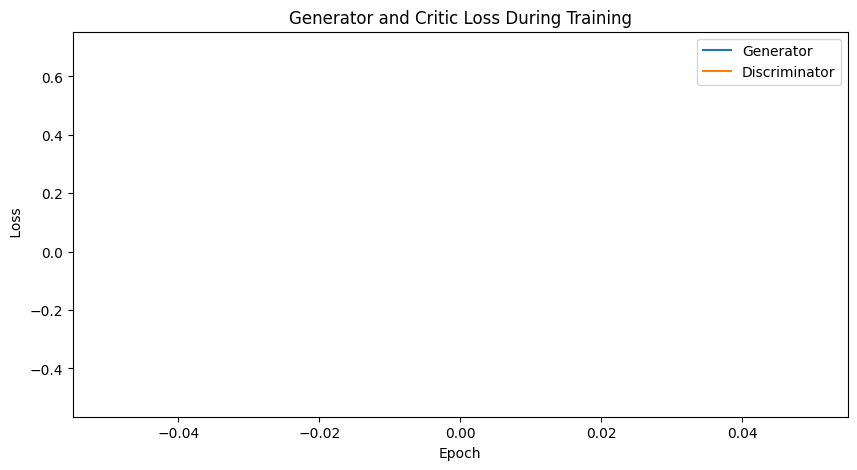

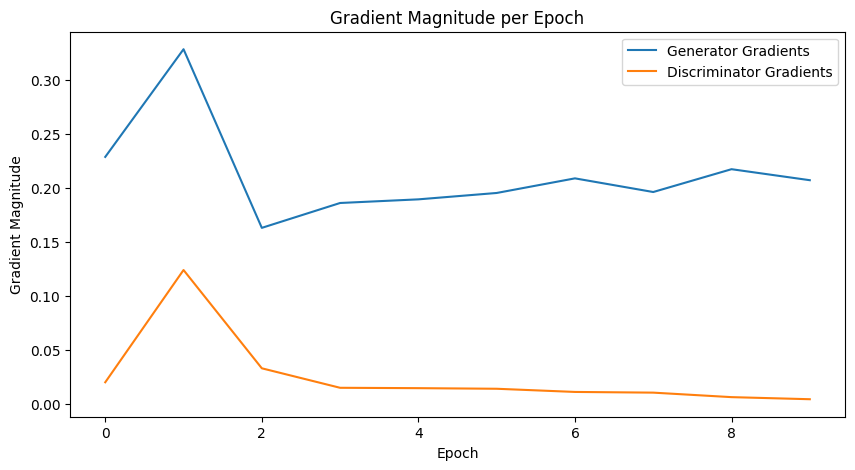

(100,) (100,)


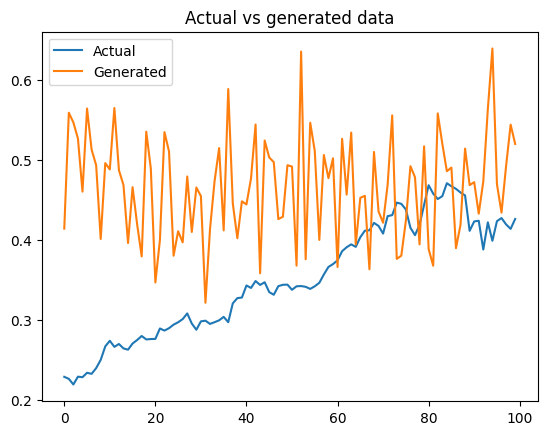

 MAE: 0.126600  , MSE 0.023062, RMSE 0.151862, MSPE 0.295677, MAPE 0.417478, R2 -3.607875, KL 0.032318


In [ ]:
# read the csv file
df = pd.read_csv('oil.csv')
df = df[6:]

df = df[['Price', 'SENT']]  # Price, WTI, SENT, GRACH
target_column = 'Price'
train_size, valid_size, test_size = 2000, 260, 100

data = create_dataset(df, target_column, train_size, valid_size, test_size, config.seq_len, config.pred_len)


x_train = torch.tensor(data['X_train'], device=device, dtype=torch.float32)
y_train = torch.tensor(data['y_train'], device=device, dtype=torch.float32)
x_val = torch.tensor(data['X_valid'], device=device, dtype=torch.float32)
y_val = data['y_valid']


#build the model

generator = Generator(hidden_dim=config.generator_latent_size, feature_no=len(df.columns),
                        seq_len= config.seq_len, output_dim=config.pred_len, dropout=config.dropout).to(device)
discriminator = Discriminator(seq_len=config.seq_len,
                                hidden_dim=config.discriminator_latent_size).to(device)

optimizer_g = torch.optim.RMSprop(generator.parameters(), lr=config.lr)
optimizer_d = torch.optim.RMSprop(discriminator.parameters(), lr=config.lr)
adversarial_loss = nn.BCELoss()
adversarial_loss = adversarial_loss.to(device)


#################################################
# Training the model
#################################################
is_train = True
best_crps = np.inf
is_train = True
if is_train:
    trained_model, runtime = train(best_crps)
else:
    print('training mode is off')

#################################################
# Testing the model
#################################################


checkpoint = torch.load('checkpoint.pt')
generator.load_state_dict(checkpoint['g_state_dict'])

x_test = torch.tensor(data['X_test'], device=device, dtype=torch.float32)
predictions = []

with torch.no_grad():
    generator.eval()
    noise_batch = generate_noise(config.noise_size, x_test.size(0), config.noise_type, rs)
    predictions.append(generator(x_test, noise_batch, batch_size=1).detach().cpu().numpy().flatten())

predictions = np.stack(predictions).flatten()
y_test = data['y_test'].flatten()
trues = data['y_test'].flatten()
preds = predictions.flatten()

#################################################
# Ploting
#################################################

plot_trues_preds(trues, preds, False)
metrics = metric(trues, preds)
metrics['crps'] = best_crps
